# Tutorial on Bayesian linear regression

**Alfredo Garbuno-Inigo**  
Phd student, University of Liverpool  
Institute for Risk and Uncertainty

In [223]:
%matplotlib inline
from pymc3 import *
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Case study: Admittance to university. 


In [2]:
d = {'dept': ['A','A','B','B','C','C','D','D','E','E','F','F'], 
    'gender': ['male','female','male','female','male','female','male','female','male','female','male','female'], 
    'admit': [512,89,353,17,120,202,138,131,53,94,22,24], 
    'reject': [313,19, 207, 8,205,391 ,279, 244, 138 ,299, 351, 317], 
     'applications': [825,108,560,25,325,593,417,375,191,393,373,341]
    }
df = pd.DataFrame(d)

In [3]:
print 'Number of records: %s' %(df.shape[0])
print 'Number of features: %s' %(df.shape[1])

Number of records: 12
Number of features: 5


In [4]:
df.head(3)

,admit,applications,dept,gender,reject
0,512,825,A,male,313
1,89,108,A,female,19
2,353,560,B,male,207


In [5]:
dfsum = df.sum()[['admit','reject','applications']]
dfsum

admit           1755
reject          2771
applications    4526
dtype: object

# Case study: Admittance to university. 

In [6]:
print 'Acceptance rate: %s' %(np.ceil(100*(dfsum['admit']+0.0)/dfsum['applications']))

Acceptance rate: 39.0


In [7]:
df.groupby('gender').sum().apply(lambda x: (100*x['admit']+0.)/x['applications'], axis=1)

gender
female    30.354223
male      44.518766
dtype: float64

In [8]:
df.groupby('dept').sum()[['admit','reject', 'applications']]

,admit,reject,applications
dept,,,
A,601,332,933
B,370,215,585
C,322,596,918
D,269,523,792
E,147,437,584
F,46,668,714


In [9]:
pd.pivot_table(df, values = 'applications', index = 'dept', columns = 'gender', aggfunc=np.sum)

gender,female,male
dept,,
A,108,825
B,25,560
C,593,325
D,375,417
E,393,191
F,341,373


In [10]:
df.groupby('dept').sum().apply(lambda x: 100.0*x[['admit','reject']]/x['applications'],axis=1)

,admit,reject
dept,,
A,64.415863,35.584137
B,63.247863,36.752137
C,35.076253,64.923747
D,33.964646,66.035354
E,25.171233,74.828767
F,6.442577,93.557423


In [11]:
depts = df.dept.unique()
n_depts = len(depts)
dept_table = dict(zip(depts, range(n_depts)))
dept = df.dept.replace(dept_table).values

dept_table

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [12]:
gender = df.gender.replace(dict(zip(df.gender.unique(), range(2))))

dict(zip(df.gender.unique(), range(2)))

{'female': 1, 'male': 0}

## Pooled model

$$ \begin{align}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha & \sim \mathcal{N}(0,1)
\end{align}
$$ 

In [13]:
with Model() as pooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0, shape=2)
    # Linear model
    theta = beta[0] + beta[1]*gender

    # This just computes the link function, no posterior sampling
    # p = pm.invlogit(theta)
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [14]:
n_samples = 3000
n_opt = 20000
n_warm = 1000

with pooled_model:
    pooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 447.82:  48%|████▊     | 9677/20000 [00:01<00:01, 6687.47it/s]
Convergence archived at 10000
Interrupted at 10,000 [50%]: Average Loss = 553.29
100%|██████████| 4000/4000 [00:07<00:00, 566.33it/s]


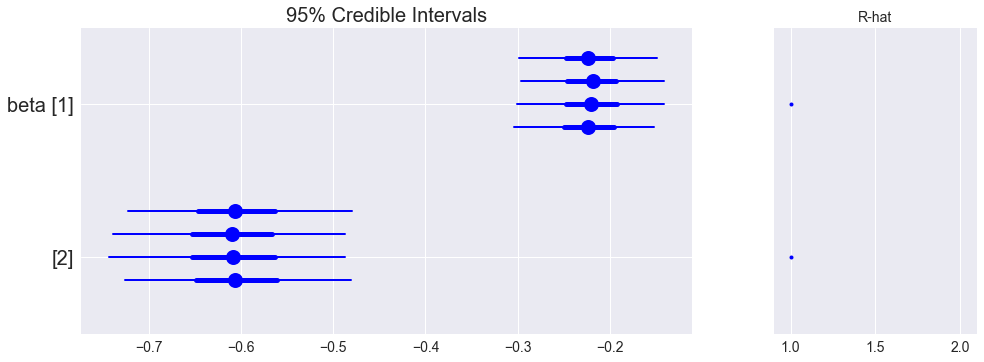

In [15]:
plt.figure(figsize=(15, 5))
forestplot(pooled_trace[n_warm:], varnames = ['beta'], fontsize = 20, linewidth = 5, marker = 'o', markersize = 15, chain_spacing = .15);

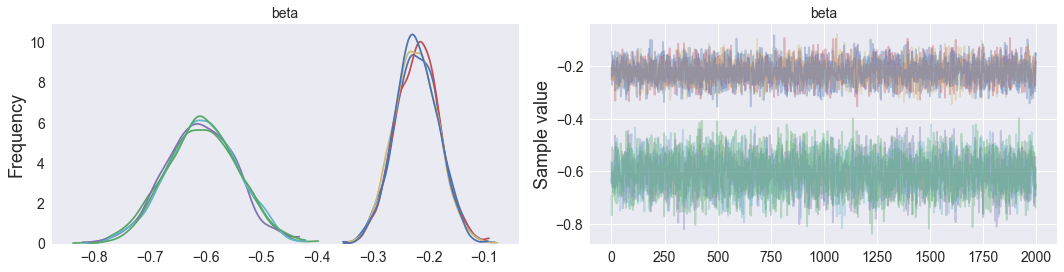

In [16]:
pm.traceplot(pooled_trace[1000:], varnames = ['beta'], figsize=(15, 4));

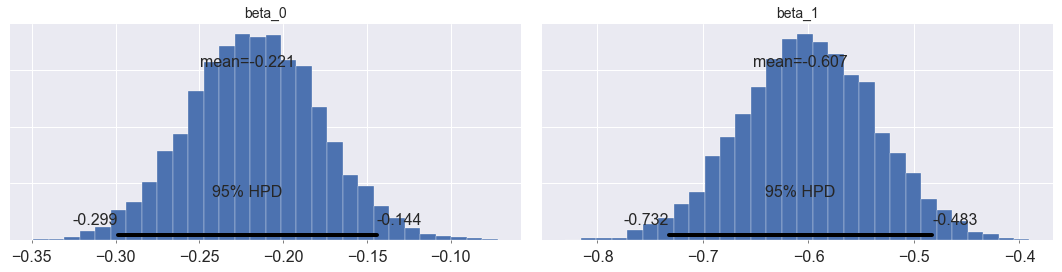

In [17]:
pm.plot_posterior(pooled_trace[1000:], varnames = ['beta'], figsize=(15, 4));

In [18]:
dfsort = df.sort_values(['dept','gender'],ascending=[True, False])
pobs = 1.*dfsort['admit']/dfsort['applications']

phat = pd.Series(pooled_trace[n_warm:]['p'].mean(axis = 0))
pstd = np.sqrt(phat*(1 - phat)/dfsort.applications)

In [19]:
x_loc = [1.5, 3.5, 5.5, 7.5, 9.5]

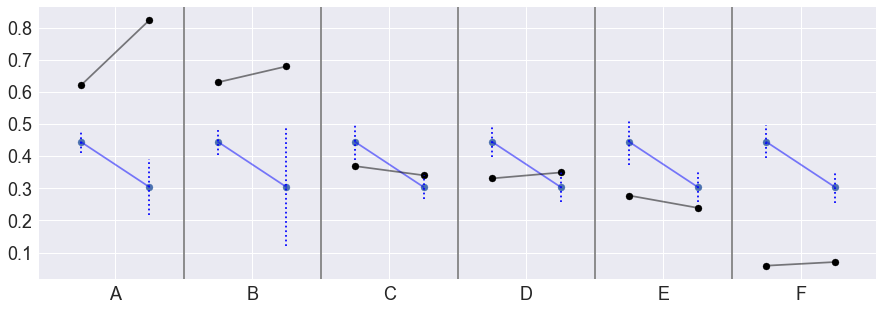

In [20]:
plt.figure(figsize=(15, 5)); 
plt.scatter(range(len(phat)), phat); 
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat[i], phat[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique(), fontsize = 18); plt.yticks(fontsize = 18);

## Unpooled model

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(0,1) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\
\end{array}
\end{align}
$$ 

In [21]:
with Model() as unpooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0)
    alpha = Normal('alpha', 0, sd = 1e0, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta * gender
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [22]:
with unpooled_model:
    unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 69.55:  63%|██████▎   | 12692/20000 [00:01<00:01, 6318.77it/s] 
Convergence archived at 12700
Interrupted at 12,700 [63%]: Average Loss = 227.14
100%|██████████| 4000/4000 [00:10<00:00, 370.42it/s]


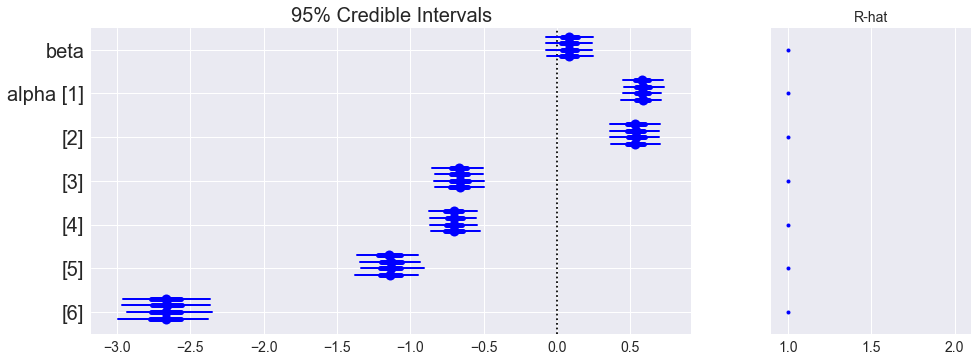

In [23]:
plt.figure(figsize=(15, 5))
forestplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'], fontsize = 20, linewidth = 5, marker = 'o', markersize = 10, chain_spacing = .15);

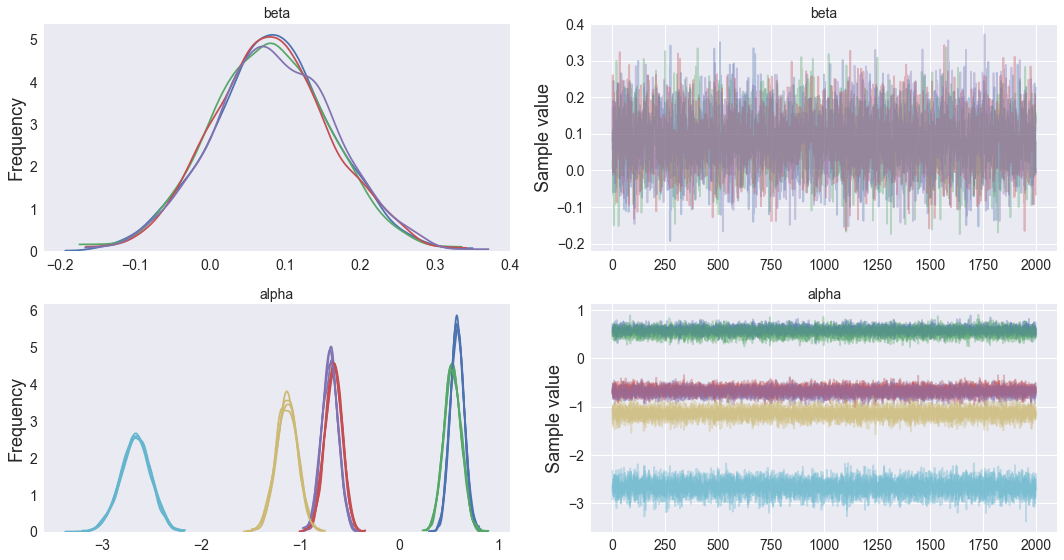

In [24]:
pm.traceplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'], figsize = (15, 8));

In [25]:
phat_unpooled = pd.Series(unpooled_trace[n_warm:]['p'].mean(axis = 0))
pstd_unpooled = np.sqrt(phat_unpooled*(1 - phat_unpooled)/dfsort.applications)

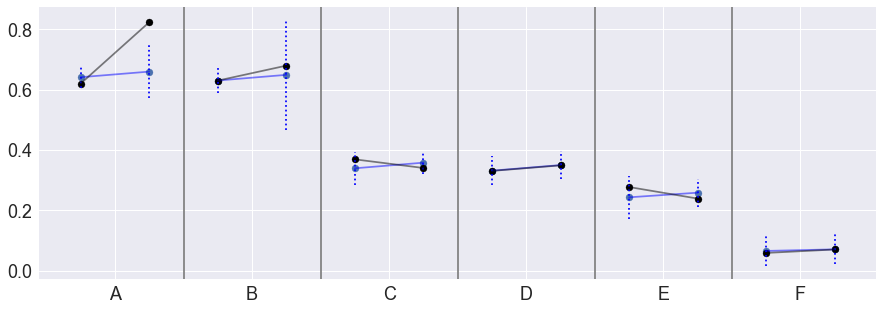

In [26]:
plt.figure(figsize=(15, 5)); plt.scatter(range(len(phat)), phat_unpooled); plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_unpooled, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_unpooled[i], phat_unpooled[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique(), fontsize = 18); plt.yticks(fontsize = 18);

## Hierarchical: *varying intercept*

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(\mu_a,\sigma_a) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\mu_a & \sim \mathcal{N}(0,10) \\
\sigma_a & \sim \text{HalfCauchy}(0,2)
\end{array}
\end{align}
$$ 

In [27]:
with Model() as hierarchical:
    # Priors in highest hierarchy
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = Exponential('sigma_a', 1)
    
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[dept] + beta * gender
    p = pm.Deterministic('p', pm.invlogit(theta))
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [28]:
with hierarchical:
    hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 73.914:  60%|█████▉    | 11935/20000 [00:02<00:01, 5040.47it/s]
Convergence archived at 12200
Interrupted at 12,200 [61%]: Average Loss = 239.49
100%|██████████| 4000/4000 [00:13<00:00, 291.12it/s]


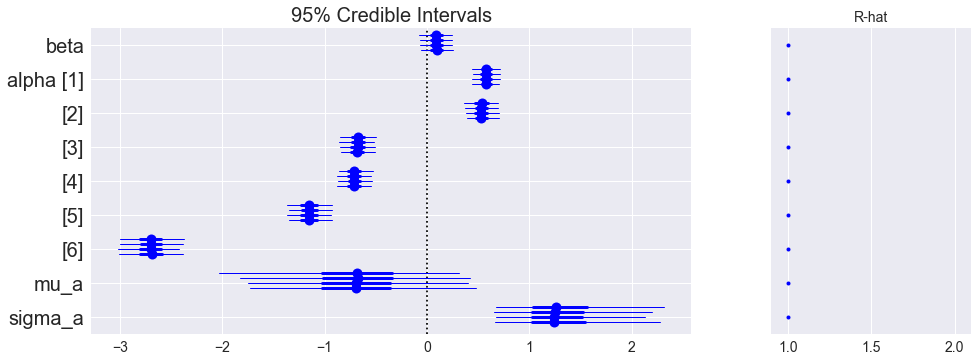

In [29]:
_ = plt.figure(figsize=(15, 5))
forestplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha', 'mu_a', 'sigma_a'], fontsize = 20, linewidth = 3, marker = 'o', markersize = 10, chain_spacing = .15);

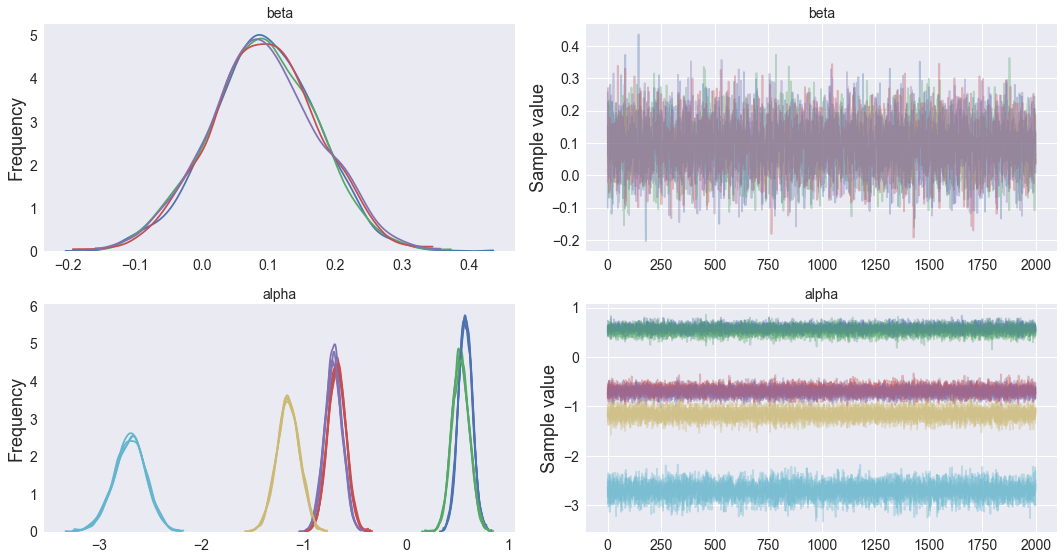

In [30]:
pm.traceplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha'], figsize =(15,8));

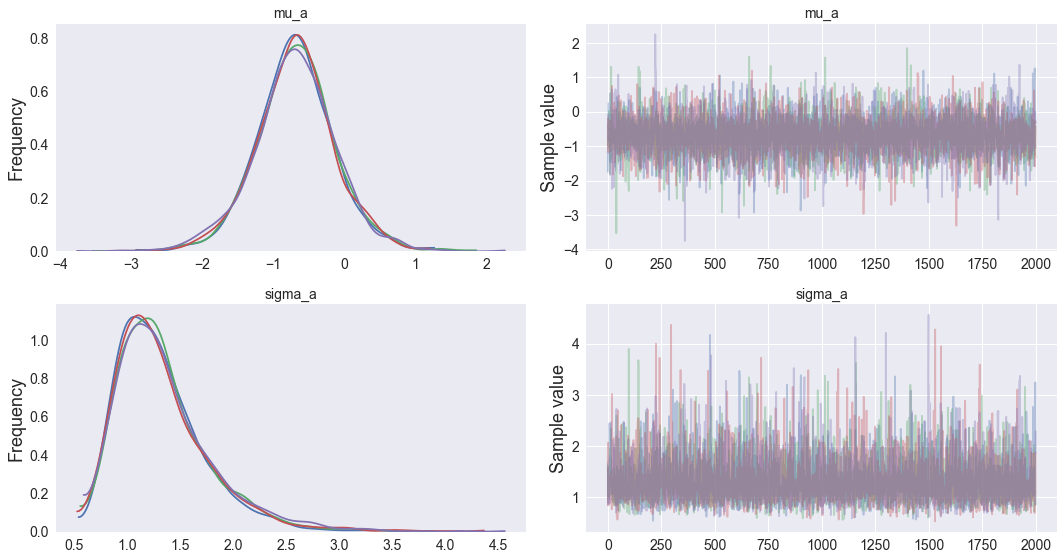

In [31]:
pm.traceplot(hierarchical_trace[1000:], varnames = ['mu_a', 'sigma_a'], figsize = (15,8));

In [32]:
phat_hierarchical = pd.Series(hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_hierarchical = np.sqrt(phat_hierarchical*(1 - phat_hierarchical)/dfsort.applications)

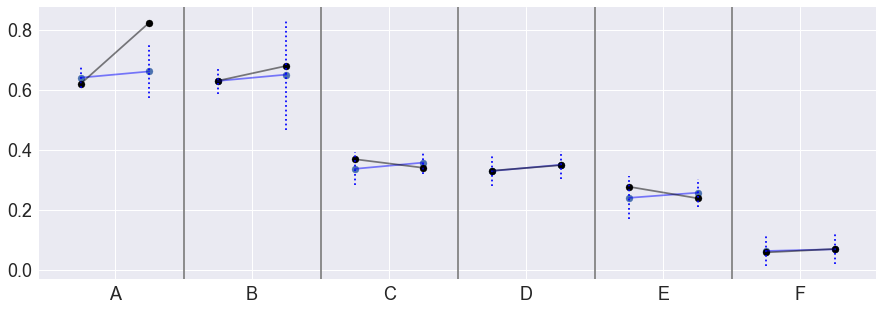

In [33]:
plt.figure(figsize=(15, 5)); plt.scatter(range(len(phat)), phat_hierarchical); plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_hierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_hierarchical[i], phat_hierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique(), fontsize = 18); plt.yticks(fontsize = 18);

## Full hierarchical: *Varying slope and intercept*

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta_{\text{DEPT}[i]} \, m_i \\
\beta_{\text{DEPT}} & \sim \mathcal{N}(\mu_b,\sigma_b) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\alpha_{\text{DEPT}} & \sim \mathcal{N}(\mu_a,\sigma_a) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\mu_a & \sim \mathcal{N}(0,10) \\
\mu_b & \sim \mathcal{N}(0,10) \\
\sigma_a & \sim \text{HalfCauchy}(0,2)\\
\sigma_b & \sim \text{HalfCauchy}(0,2)
\end{array}
\end{align}
$$ 

In [34]:
with Model() as full_hierarchical:
    # Priors in highest hierarchy
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = Exponential('sigma_a', 1)
    mu_b = Normal('mu_b', mu=0., sd=1e1)
    sigma_b = Exponential('sigma_b', 1)
    
    # Priors in regression coefficients
    beta = Normal('beta', mu_b, sd=sigma_b, shape = n_depts)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[dept] + beta[dept] * gender
    p = pm.Deterministic('p', pm.invlogit(theta))  
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [35]:
n_samples = 5000
n_warm = 2000

with full_hierarchical:
    full_hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 73.138:  70%|██████▉   | 13972/20000 [00:03<00:01, 4308.98it/s]
Convergence archived at 14300
Interrupted at 14,300 [71%]: Average Loss = 207.41
100%|█████████▉| 6988/7000 [00:43<00:00, 147.24it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 0 contains 32 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 7000/7000 [00:43<00:00, 159.81it/s]
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 32 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning:

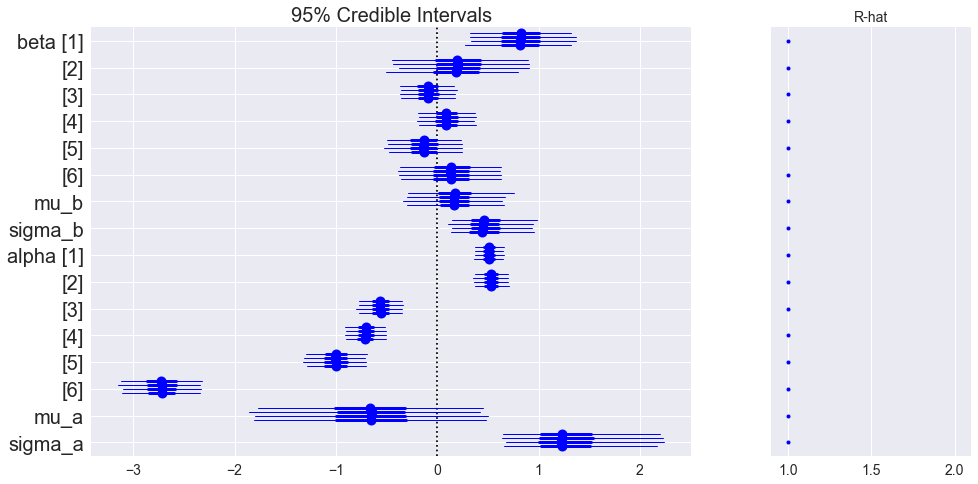

In [36]:
_ = plt.figure(figsize=(15, 7)); 
forestplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'mu_b','sigma_b','alpha', 'mu_a', 'sigma_a'], fontsize = 20, linewidth = 3, marker = 'o', markersize = 10, chain_spacing = .15);

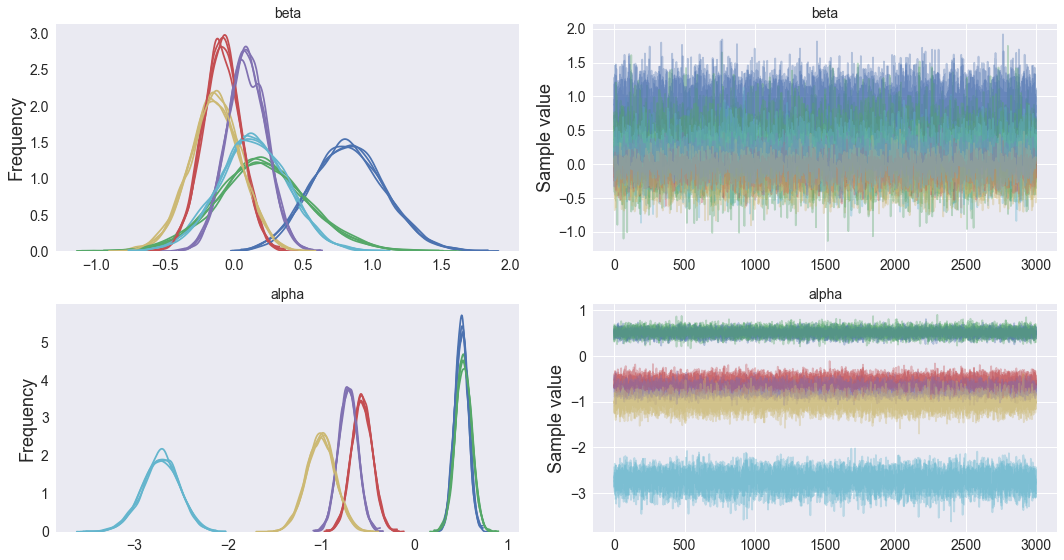

In [37]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha'], figsize=(15, 8)); 

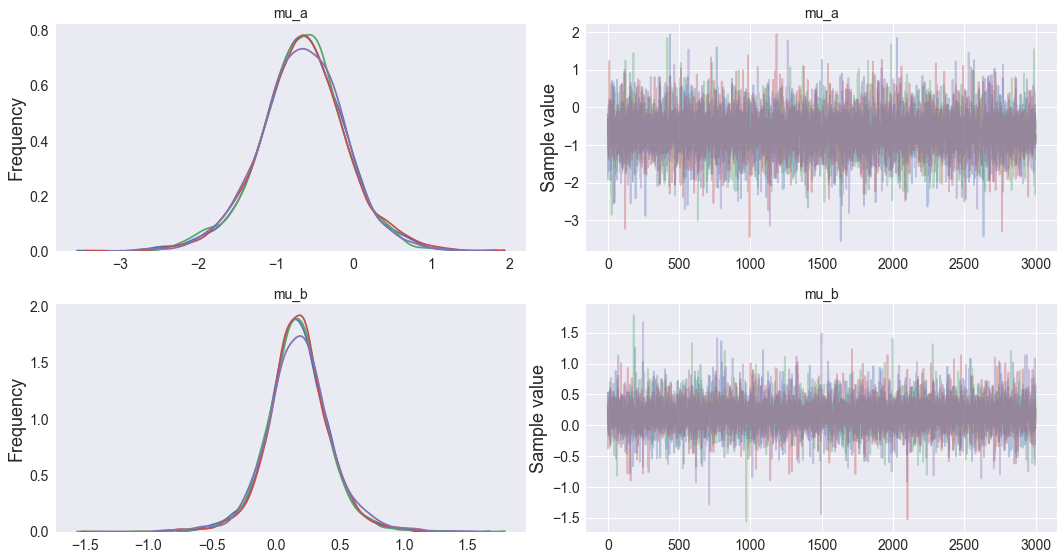

In [38]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['mu_a', 'mu_b'], figsize=(15, 8)); 

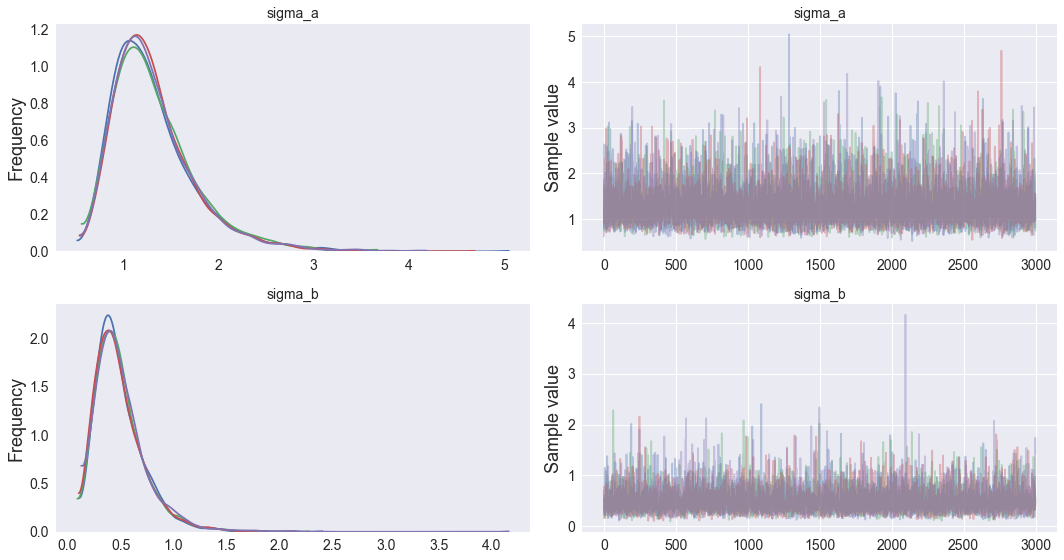

In [39]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['sigma_a', 'sigma_b'], figsize=(15, 8));

In [40]:
phat_fhierarchical = pd.Series(full_hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_fhierarchical = np.sqrt(phat_fhierarchical*(1 - phat_fhierarchical)/dfsort.applications)

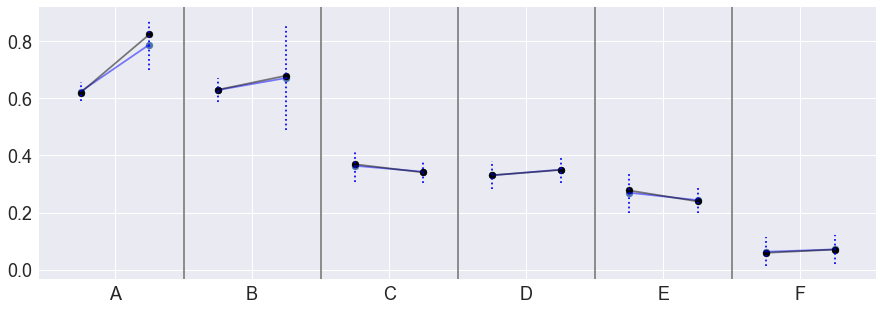

In [41]:
plt.figure(figsize=(15, 5)); plt.scatter(range(len(phat)), phat_fhierarchical); plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_fhierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_fhierarchical[i], phat_fhierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique(), fontsize = 18); plt.yticks(fontsize = 18);

## Model comparison and model averaging

Instead of comparing likelihoods (never!)

* Deviance Information criteria (DIC)  

* Watanabe-Akaike Information criteria (WAIC)  

### DIC

In [42]:
traces = [pooled_trace, unpooled_trace, hierarchical_trace, full_hierarchical_trace]
models = [pooled_model, unpooled_model, hierarchical, full_hierarchical]
models_list = ['Pooled '+'.'*23, 'Unpooled '+'.'*21, 'Varying intercept '+'.'*12, 'Varying intercept and slope ..']

for t, m, n in zip(traces, models, models_list):
    print '%s \t : %s' %(n, pm.stats.dic(t,m))

Pooled ....................... 	 : 860.601133987
Unpooled ..................... 	 : 126.198018864
Varying intercept ............ 	 : 136.228636077
Varying intercept and slope .. 	 : 141.586634867


### WAIC

In [48]:
pm.stats.waic(full_hierarchical_trace, full_hierarchical)

WAIC_r(WAIC=89.691365572804045, WAIC_se=4.0920629376652133, p_WAIC=6.2245108592653011)

In [49]:
pm.stats.compare(traces, models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
3,89.6914,6.22451,0,0.999845,4.09206,0,0
2,108.478,9.33678,18.7865,8.32733e-05,15.7176,13.7432,0
1,108.786,9.52947,19.0947,7.13791e-05,16.2085,14.2465,0
0,992.893,111,903.201,7.45219e-197,314.27,314.718,0


## Shrinkage

In [ ]:
with Model() as unpooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0, shape = n_depts)
    alpha = Normal('alpha', 0, sd = 1e0, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta[dept] * gender
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [ ]:
with unpooled_model:
    unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

In [ ]:
plt.figure(figsize=(15, 5));
plt.scatter(unpooled_trace[n_warm:]['alpha'].mean(axis=0), 
            unpooled_trace[n_warm:]['beta'].mean(axis=0), c ='k', label = 'unpooled');
plt.scatter(full_hierarchical_trace[n_warm:]['alpha'].mean(axis=0), 
            full_hierarchical_trace[n_warm:]['beta'].mean(axis=0), c ='r', label = 'hierarchical');
plt.legend(fontsize = 18, bbox_to_anchor=(1.05, 0.65), loc=2, borderaxespad=0.);
plt.xlabel('Intercept estimates'); plt.ylabel('Slope intercept');

## Another example: tadpole mortality

In [70]:
d = {
    'density' : [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35], 
     'surv' : [9,10,7,10,9,9,10,9,4,9,7,6,7,5,9,9,24,23,22,25,23,23,23,21,6,13,4,9,13,20,8,10,34,33,33,31,31,35,33,32,4,12,13,14,22,12,31,17], 
     'tank' : range(48)
    }
df = pd.DataFrame(d)
n_tanks = 48
tank = df.tank.values

In [61]:
df.head()

,density,surv,tank
0,10,9,0
1,10,10,1
2,10,7,2
3,10,10,3
4,10,9,4


## Unpooled model

In [271]:
with Model() as tad_unpooled:
    alpha = Normal('alpha', 0, sd = 7e1, shape=n_tanks)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[tank]
    p = pm.Deterministic('p', pm.invlogit(theta))  
    y = Binomial('y', n = df.density, p = p, observed = df.surv)

In [272]:
n_samples = 3000
n_warm = 1000
n_opt = 50000

with tad_unpooled:
    tad_unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 281.18: 100%|██████████| 50000/50000 [00:07<00:00, 6662.84it/s]
Finished [100%]: Average Loss = 281.13
 87%|████████▋ | 3483/4000 [02:07<00:19, 26.87it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000 [02:26<00:00, 27.37it/s]


## Partially pooled model (*hierarchical*)

In [107]:
with Model() as tad_ppooled:
    mu_a = Normal('mu_a', 0, sd = 1)
    sigma_a = Exponential('sigma_a', 1)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_tanks)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[tank]
    p = pm.Deterministic('p', pm.invlogit(theta))  
    y = Binomial('y', n = df.density, p = p, observed = df.surv)

In [108]:
with tad_ppooled:
    tad_ppooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 139.32:  32%|███▏      | 15750/50000 [00:03<00:06, 5263.08it/s]
Convergence archived at 16100
Interrupted at 16,100 [32%]: Average Loss = 203.3
100%|██████████| 4000/4000 [00:13<00:00, 287.83it/s]


In [200]:
tad_models = [tad_unpooled, tad_ppooled]
tad_traces = [tad_unpooled_trace, tad_ppooled_trace]

## Model comparison and averaging

In [201]:
pm.stats.compare(tad_traces, tad_models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,199.656,20.6221,0,0.940248,7.27961,0,0
0,205.168,24.6593,5.51189,0.0597518,10.7232,6.43464,0


Both have a reduced number of effective parameters by means of a prior.  
The unpooled model is using a fixed prior.  
The partially pooled model is using a prior learned from data.

In [191]:
phat = np.median(tad_ppooled_trace[n_warm:]['p'], axis = 0)
punp = np.median(tad_unpooled_trace[n_warm:]['p'], axis = 0)
pobs = (1.*df.surv/df.density).values

a = np.median(tad_ppooled_trace[n_warm:]['mu_a'], axis = 0)
a = np.exp(a)/(1+np.exp(a))

x_loc = (16.5, 32.5)

## Adaptive regularising priors

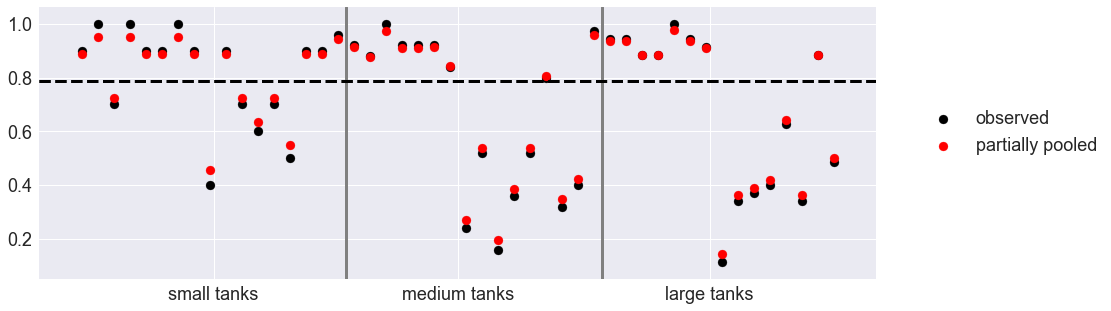

In [198]:
plt.figure(figsize=(15, 5));
plt.scatter(range(len(phat)), pobs, label = 'observed', s = 80, c= 'k');
# plt.scatter(range(len(phat)), punp, label = 'unpooled', c = 'g', s = 80);
plt.scatter(range(len(phat)), phat, label = 'partially pooled', c = 'r', s = 80);
plt.legend(fontsize = 18, bbox_to_anchor=(1.05, 0.65), loc=2, borderaxespad=0.);
for xc in x_loc: plt.axvline(x=xc, color = 'gray', linewidth = 3); plt.axhline(y = a, linestyle = '--', c = 'k', linewidth = 3)
plt.xticks((16.5/2, (16.5+30.5)/2, (30.5+48)/2) , ['small tanks', 'medium tanks', 'large tanks'], fontsize = 18); plt.yticks(fontsize = 18);

## Use the hierarchical model to simulate new tanks!

In [237]:
ma = tad_ppooled_trace[n_warm:]['mu_a']
sa = tad_ppooled_trace[n_warm:]['sigma_a']

index = np.random.randint(0, ma.shape[0], 100)
h = np.arange(-4,4,.1)

samples = np.empty((0,0))

for m, s in zip(ma[index], sa[index]):
    samples = np.append(samples, np.random.normal(m,s,100))

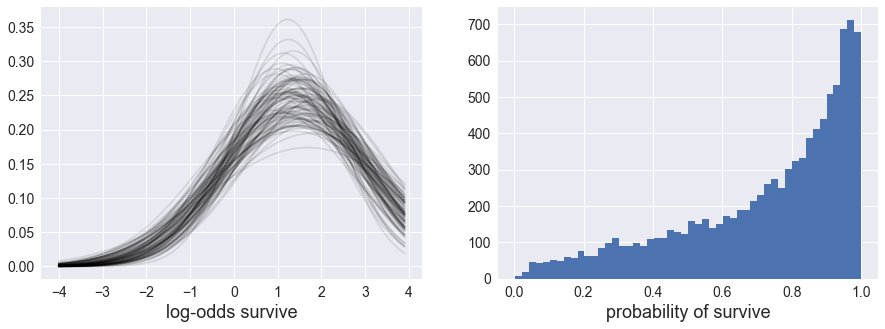

In [273]:
fig = plt.figure(figsize=(15, 5));
ax1 = fig.add_subplot(121)
for m, s in zip(ma[index], sa[index]):
    plt.plot(h, stats.norm.pdf(h,m,s), c = 'k', alpha = 0.1)
ax1.set_xlabel('log-odds survive'); 
    
ax2 = fig.add_subplot(122)
plt.hist(np.exp(samples) / (1+ np.exp(samples)), bins= 50);
ax2.set_xlabel('probability of survive');

## Yet another example: Poisson regression and the count of tools

In [282]:
d = {'culture' :['Malekula','Tikopia','Santa Cruz','Yap','Lau Fiji','Trobriand','Chuuk','Manus','Tonga','Hawaii'],
     'population': [1100,   1500,   3600,   4791,   7400,   8000,   9200,  13000,  17500 ,275000],
     'tools':[13, 22, 24, 43, 33, 19, 40, 28, 55, 71], 
     'contact':['low','low','low','high','high','high','high','low','high','low']
    }
df = pd.DataFrame(d)    

In [284]:
df

,contact,culture,population,tools
0,low,Malekula,1100,13
1,low,Tikopia,1500,22
2,low,Santa Cruz,3600,24
3,high,Yap,4791,43
4,high,Lau Fiji,7400,33
5,high,Trobriand,8000,19
6,high,Chuuk,9200,40
7,low,Manus,13000,28
8,high,Tonga,17500,55
9,low,Hawaii,275000,71


In [286]:
log_pop = np.log(df.population)
contact = df.contact.replace(dict(zip(df.contact.unique(), range(2))))

In [292]:
with Model() as island_m1:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    beta = Normal('beta', 0, sd = 1e0, shape = 3)
    # Linear Model
    theta = alpha + beta[0] * log_pop + beta[1] * contact + beta[2] * contact * log_pop
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m1_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 1)    

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 5.5045e+16:   1%|▏         | 688/50000 [00:00<00:07, 6877.66it/s]
Convergence archived at 900
Interrupted at 900 [1%]: Average Loss = 1.6915e+08
100%|██████████| 4000/4000 [00:26<00:00, 149.68it/s]


In [293]:
with Model() as island_m2:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    beta = Normal('beta', 0, sd = 1e0, shape = 2)
    # Linear Model
    theta = alpha + beta[0] * log_pop + beta[1] * contact 
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m2_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 1) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 4.8774e+06:   4%|▍         | 1934/50000 [00:00<00:07, 6466.92it/s]
Convergence archived at 2000
Interrupted at 2,000 [4%]: Average Loss = 7.6638e+06
100%|██████████| 4000/4000 [00:15<00:00, 260.66it/s]


In [294]:
with Model() as island_m3:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    beta = Normal('beta', 0, sd = 1e0, shape = 1)
    # Linear Model
    theta = alpha + beta[0] * log_pop 
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m3_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 1) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
  0%|          | 0/50000 [00:00<?, ?it/s]
Convergence archived at 400
Interrupted at 400 [0%]: Average Loss = 4.4111e+08
100%|██████████| 4000/4000 [00:08<00:00, 446.21it/s]


In [296]:
with Model() as island_m4:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    beta = Normal('beta', 0, sd = 1e0, shape = 1)
    # Linear Model
    theta = alpha + beta[0] * contact
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m4_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 78.738:  35%|███▍      | 17421/50000 [00:02<00:04, 7877.43it/s]
Convergence archived at 18100
Interrupted at 18,100 [36%]: Average Loss = 275.95
100%|██████████| 4000/4000 [00:08<00:00, 492.86it/s]


In [297]:
with Model() as island_m5:
    # Priors
    alpha = Normal('alpha', 0, sd = 1e2)
    # Linear Model
    theta = alpha
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_m5_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 76.958:  33%|███▎      | 16358/50000 [00:02<00:04, 7681.51it/s]
Convergence archived at 17000
Interrupted at 17,000 [34%]: Average Loss = 328.7
100%|██████████| 4000/4000 [00:04<00:00, 924.00it/s]


In [320]:
traces = [island_m1_trace, island_m2_trace, island_m3_trace, island_m4_trace, island_m5_trace]
models = [island_m1, island_m2, island_m3, island_m4, island_m5]

## Model averaging

In [331]:
pm.stats.compare(traces, models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,79.0573,4.18772,0,0.630337,11.002,0,0
0,80.3229,4.97092,1.26553,0.334785,11.2877,1.22663,0
2,84.8462,3.97545,5.78883,0.0348774,8.94292,7.97378,0
4,141.765,8.42659,62.7081,1.52292e-14,31.8737,32.8925,0
3,151.421,17.1235,72.3639,1.21888e-16,45.9487,45.6117,0


In [527]:
index = np.random.randint(0,2000,100)
beta_m2 = island_m2_trace[n_warm:]['beta']
alpha_m2 = island_m2_trace[n_warm:]['alpha']

hicontact = np.exp((alpha_m2 + beta_m2[:,1])[index,np.newaxis] + np.multiply(beta_m2[:,0][index,np.newaxis], h))
locontact = np.exp((alpha_m2)[index,np.newaxis] + np.multiply(beta_m2[:,0][index,np.newaxis], h))

In [528]:
index = np.random.randint(0,2000,100)
beta_m1 = island_m1_trace[n_warm:]['beta']
alpha_m1 = island_m1_trace[n_warm:]['alpha']

hicontact1 = np.exp((alpha_m1 + beta_m1[:,1])[index,np.newaxis] + np.multiply(beta_m1[:,np.arange(0,3,2)].sum(axis=1)[index,np.newaxis], h))
locontact1 = np.exp((alpha_m1)[index,np.newaxis] + np.multiply(beta_m1[:,0][index,np.newaxis], h))

In [559]:
def plot_modelavg():
    fig = plt.figure(figsize=(15, 5));
    plt.subplot(131)
    plt.plot(h, np.percentile(hicontact, [50], axis = 0).T, 'r', label = 'high contact');
    plt.plot(h, np.percentile(locontact, [50], axis = 0).T, 'b', label = 'low contact');
    plt.legend(fontsize = 18, loc=0);
    plt.fill_between(h, np.percentile(hicontact,[5],axis=0)[0], np.percentile(hicontact,[95],axis=0)[0],facecolor='r',alpha=.2);
    plt.fill_between(h, np.percentile(locontact,[5],axis=0)[0], np.percentile(locontact,[95],axis=0)[0],facecolor='b',alpha=.2);
    plt.scatter(log_pop[contact==1], df.tools[contact==1],c='r');
    plt.scatter(log_pop[contact==0], df.tools[contact==0],c='b');

    plt.ylim((15,100))

    plt.subplot(132)
    plt.plot(h, np.percentile(hicontact1, [50], axis = 0).T, 'r', label = 'high contact');
    plt.plot(h, np.percentile(locontact1, [50], axis = 0).T, 'b', label = 'low contact');
    plt.legend(fontsize = 18, loc=0);
    plt.fill_between(h, np.percentile(hicontact1,[5],axis=0)[0], np.percentile(hicontact1,[95],axis=0)[0],facecolor='r',alpha=.2);
    plt.fill_between(h, np.percentile(locontact1,[5],axis=0)[0], np.percentile(locontact1,[95],axis=0)[0],facecolor='b',alpha=.2);
    plt.scatter(log_pop[contact==1], df.tools[contact==1],c='r');
    plt.scatter(log_pop[contact==0], df.tools[contact==0],c='b');

    plt.ylim((15,100))

    plt.subplot(133)
    plt.plot(h, np.percentile(.65*hicontact+.35*hicontact1, [50], axis = 0).T, 'r', label = 'high contact');
    plt.plot(h, np.percentile(.65*locontact+.35*locontact1, [50], axis = 0).T, 'b', label = 'low contact');
    plt.legend(fontsize = 18, loc=0);
    
    plt.plot(h, np.percentile(hicontact1, [50], axis = 0).T, 'r--');
    plt.plot(h, np.percentile(hicontact, [50], axis = 0).T, 'r:');
    plt.plot(h, np.percentile(locontact1, [50], axis = 0).T, 'b--');
    plt.plot(h, np.percentile(locontact, [50], axis = 0).T, 'b:');
    
    plt.fill_between(h, np.percentile(hicontact,[5],axis=0)[0], np.percentile(hicontact,[95],axis=0)[0],facecolor='r',alpha=.1);
    plt.fill_between(h, np.percentile(hicontact1,[5],axis=0)[0], np.percentile(hicontact1,[95],axis=0)[0],facecolor='r',alpha=.1);
    plt.fill_between(h, np.percentile(.65*hicontact+.35*hicontact1,[5],axis=0)[0], np.percentile(.65*hicontact+.35*hicontact1,[95],axis=0)[0],facecolor='r',alpha=.3);

    plt.fill_between(h, np.percentile(locontact,[5],axis=0)[0], np.percentile(locontact,[95],axis=0)[0],facecolor='b',alpha=.1);
    plt.fill_between(h, np.percentile(locontact1,[5],axis=0)[0], np.percentile(locontact1,[95],axis=0)[0],facecolor='b',alpha=.1);
    plt.fill_between(h, np.percentile(.65*locontact+.35*locontact1,[5],axis=0)[0], np.percentile(.65*locontact+.35*locontact1,[95],axis=0)[0],facecolor='b',alpha=.3);

   
    plt.scatter(log_pop[contact==1], df.tools[contact==1],c='r');
    plt.scatter(log_pop[contact==0], df.tools[contact==0],c='b');

    plt.ylim((15,100));

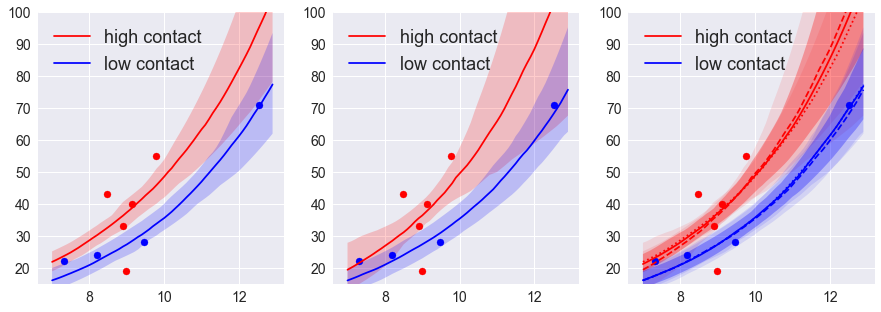

In [560]:
plot_modelavg()

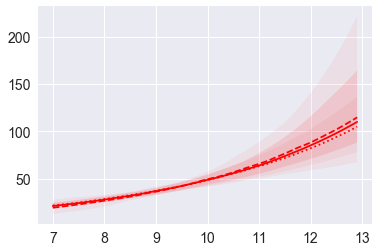

In [553]:
plt.plot(h, np.percentile(hicontact1, [50], axis = 0).T, 'r--', label = 'high contact');
plt.plot(h, np.percentile(hicontact, [50], axis = 0).T, 'r:', label = 'high contact');
plt.plot(h, np.percentile(.65*hicontact + .35*hicontact1, [50], axis = 0).T, 'r', label = 'high contact');

plt.fill_between(h, np.percentile(hicontact,[5],axis=0)[0], np.percentile(hicontact,[95],axis=0)[0],facecolor='r',alpha=.05);
plt.fill_between(h, np.percentile(hicontact1,[5],axis=0)[0], np.percentile(hicontact1,[95],axis=0)[0],facecolor='r',alpha=.05);
plt.fill_between(h, np.percentile(.65*hicontact+.35*hicontact1,[5],axis=0)[0], np.percentile(.65*hicontact+.35*hicontact1,[95],axis=0)[0],facecolor='r',alpha=.1);

In [561]:
society = np.arange(10)

## Hierarchical model

In [563]:
with Model() as island_multi:
    # Priors
    sigma_soc = HalfCauchy('sigma_soc', 1)
    
    alpha = Normal('alpha', 0, sd = 1e1)
    alpha_soc = Normal('alpha_soc', 0, sd = sigma_soc, shape = 10)
    beta = Normal('beta', 0, sd = 1e0)
    # Linear Model
    theta = alpha + alpha_soc[society] + beta * log_pop 
    # Likelihood function
    tools = Poisson('tools', mu = np.exp(theta), observed = df.tools)
    
    island_multi_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 3) 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 53.927:  57%|█████▋    | 28656/50000 [00:05<00:03, 5714.91it/s]   
Convergence archived at 29000
Interrupted at 29,000 [58%]: Average Loss = 8.343e+06
100%|██████████| 4000/4000 [01:16<00:00, 52.18it/s]


In [565]:
pm.stats.waic(island_multi_trace, island_multi)

WAIC_r(WAIC=70.11328946635328, WAIC_se=2.575676710853994, p_WAIC=5.0549400600108845)

In [566]:
traces = [island_m1_trace, island_m2_trace, island_m3_trace, island_m4_trace, island_m5_trace, island_multi_trace]
models = [island_m1, island_m2, island_m3, island_m4, island_m5, island_multi]

In [569]:
pm.stats.compare(traces, models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
5,70.1133,5.05494,0,0.982199,2.57568,0,0
1,79.0573,4.18772,8.94404,0.0112208,11.002,10.0081,0
0,80.3229,4.97092,10.2096,0.00595961,11.2877,10.114,0
2,84.8462,3.97545,14.7329,0.000620863,8.94292,6.89491,0
4,141.765,8.42659,71.6522,2.71099e-16,31.8737,31.2524,0
3,151.421,17.1235,81.3079,2.16976e-18,45.9487,45.1589,0


In [622]:
index_soc = np.random.randint(0,6000,1000)
index = np.random.randint(0,6000,1000)

alpha_m = island_multi_trace[n_warm:]['alpha']
alphasoc_m = island_multi_trace[n_warm:]['alpha_soc']
beta_m = island_multi_trace[n_warm:]['beta']
sigma_soc_m = island_multi_trace[n_warm:]['sigma_soc']

In [633]:
rsoc = np.random.normal(0,sigma_soc_m[index_soc], size = (2000,1000))

In [643]:
res = rsoc[:,:,np.newaxis] + alpha_m[index,np.newaxis] + np.multiply(beta_m[index,np.newaxis], h)

p50 = np.percentile(res, 50, axis = (0,1))
plo = np.percentile(res, [2.5, 5, 10], axis = (0,1))
phi = np.percentile(res, [97.5, 95, 90], axis = (0,1))

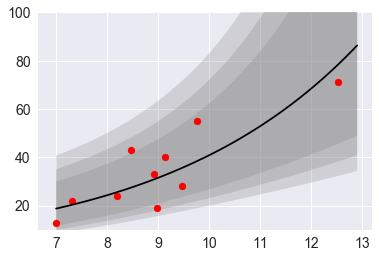

In [672]:
plt.plot(h, np.exp(p50), 'k')
plt.fill_between(h, np.exp(plo)[0], np.exp(phi)[0], facecolor = 'gray', alpha = .25)
plt.fill_between(h, np.exp(plo)[1], np.exp(phi)[1], facecolor = 'gray', alpha = .25)
plt.fill_between(h, np.exp(plo)[2], np.exp(phi)[2], facecolor = 'gray', alpha = .25)
plt.scatter(log_pop, df.tools, c = 'r');
plt.ylim((10,100));